In [89]:
import pandas as pd
import numpy as np
import tensorflow as tf
#  import matplotlib.pyplot as plt
import pylab
import os
import pydicom
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from glob import glob
from skimage import measure
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from PIL import Image
from keras.applications.densenet import DenseNet121 as PTModel, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization, GlobalAveragePooling2D, Dense, Dropout, Input,\
UpSampling2D, LeakyReLU, Conv2D, MaxPool2D
# , AvgPool2D, Lambda, LocallyConnected2D, Conv2D, multiply, Flatten
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau\
    # , LearningRateScheduler
from keras.losses import binary_crossentropy
from keras.utils import Sequence
from keras import layers
import keras_preprocessing.image as KPImage

# params we will probably want to do some hyperparameter optimization later

# ['InceptionV3', 'Xception', 'DenseNet169', 'VGG16']
BASE_MODEL = 'DenseNet121'
IMG_SIZE = (256, 256)  # [(224, 224), (384, 384), (512, 512), (640, 640)]
BATCH_SIZE = 16  # [1, 8, 16, 24]
DENSE_COUNT = 128  # [32, 64, 128, 256]
DROPOUT = 0.25  # [0, 0.25, 0.5]
LEARN_RATE = 1e-4  # [1e-4, 1e-3, 4e-3]
TRAIN_SAMPLES = 8000  # [3000, 6000, 15000]
TEST_SAMPLES = 800
USE_ATTN = False  # [True, False]

# Initialize paths to image directories
det_class_path = '../input/stage_1_detailed_class_info.csv'
bbox_path = '../input/stage_1_train_labels.csv'
dicom_dir = '../input/stage_1_train_images/'

In [2]:
# Labels contains the target (1=pneumonia, 0=healthy) and bounding boxes
# if that patient has pneumonia
bbox_df = pd.read_csv('../input/stage_1_train_labels.csv')

# Detailed contains whether patient has lung opacity, image is not normal or
# they are healthy
det_class_df = pd.read_csv('../input/stage_1_detailed_class_info.csv')
det_class_df = det_class_df.groupby('patientId').head(1).reset_index()
# Join the two tables
comb_bbox_df = pd.merge(bbox_df, det_class_df, how='outer', on='patientId')
comb_bbox_df.head(3)

# Initialize paths to image directories
det_class_path = '../input/stage_1_detailed_class_info.csv'
bbox_path = '../input/stage_1_train_labels.csv'
dicom_dir = '../input/stage_1_train_images/'
path = '../input/stage_1_train_images/%s.dcm' % comb_bbox_df['patientId'][0]
dicom_header = pydicom.read_file(path, stop_before_pixels=True)

bbox_df.head(10)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [3]:
# Labels contains the target (1=pneumonia, 0=healthy) and bounding boxes
# if that patient has pneumonia
bbox_df = pd.read_csv('../input/stage_1_train_labels.csv')
bbox_df[['x', 'y', 'width', 'height']] = bbox_df[['x', 'y', 'width', 'height']].fillna(0.0).astype('int')

# Create new dataframe with a column bbox which contains the info about the bounding box
comb_bbox_df = bbox_df
comb_bbox_df['bbox'] = bbox_df[['x', 'y', 'width', 'height']].values.tolist()
grouped_bbox_df = comb_bbox_df.groupby('patientId')['bbox'].apply(list)
grouped_bbox_df.head(10)

patientId
0004cfab-14fd-4e49-80ba-63a80b6bddd6                                  [[0, 0, 0, 0]]
00313ee0-9eaa-42f4-b0ab-c148ed3241cd                                  [[0, 0, 0, 0]]
00322d4d-1c29-4943-afc9-b6754be640eb                                  [[0, 0, 0, 0]]
003d8fa0-6bf1-40ed-b54c-ac657f8495c5                                  [[0, 0, 0, 0]]
00436515-870c-4b36-a041-de91049b9ab4    [[264, 152, 213, 379], [562, 152, 256, 453]]
00569f44-917d-4c86-a842-81832af98c30                                  [[0, 0, 0, 0]]
006cec2e-6ce2-4549-bffa-eadfcd1e9970                                  [[0, 0, 0, 0]]
00704310-78a8-4b38-8475-49f4573b2dbb    [[323, 577, 160, 104], [695, 575, 162, 137]]
008c19e8-a820-403a-930a-bc74a4053664                                  [[0, 0, 0, 0]]
009482dc-3db5-48d4-8580-5c89c4f01334                                  [[0, 0, 0, 0]]
Name: bbox, dtype: object

In [90]:
# we create two instances with the same arguments
data_gen_args = dict(samplewise_center=False, 
                     samplewise_std_normalization=False, 
                     horizontal_flip = True, 
                     vertical_flip = False, 
                     height_shift_range = 0.05, 
                     width_shift_range = 0.02, 
                     rotation_range = 3, 
                     shear_range = 0.01,
                     fill_mode = 'nearest',
                     validation_split = 0.1,
                     zoom_range = 0.05,
                     #preprocessing_function=preprocess_input
                    )
data_gen_args = {'validation_split': 0.1}
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 2018

image_dir = dicom_dir + 'sources'
target_dir = dicom_dir + 'masks'

train_image_generator = image_datagen.flow_from_directory(
    image_dir,
    class_mode=None,
    seed=seed,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='training')
train_mask_generator = mask_datagen.flow_from_directory(
    target_dir,
    class_mode=None,
    seed=seed,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='training')
valid_image_generator = image_datagen.flow_from_directory(
    image_dir,
    class_mode=None,
    seed=seed,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='validation')
valid_mask_generator = mask_datagen.flow_from_directory(
    target_dir,
    class_mode=None,
    seed=seed,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='validation')

# combine generators into one which yields image and masks
train_generator = zip(train_image_generator, train_mask_generator)
valid_generator = zip(valid_image_generator, valid_mask_generator)

Found 23116 images belonging to 1 classes.
Found 23116 images belonging to 1 classes.
Found 2568 images belonging to 1 classes.
Found 2568 images belonging to 1 classes.


In [5]:
# This takes a while and only needs to be ran once to generate all the necessary images

#for pid, boxes in grouped_bbox_df.items():
    #if os.path.isfile(os.path.join(dicom_dir, "src/" + str(pid) + ".png")):
    #    continue
    #if os.path.isfile(os.path.join(dicom_dir, "masks/msk/" + str(pid) + "-mask.png")):
    #    continue
    # load dicom file as numpy array

#    img = pydicom.dcmread(os.path.join(dicom_dir, str(pid) + ".dcm")).pixel_array
    # create empty mask
#    msk = np.zeros(img.shape, dtype=np.uint8)
    
#    if boxes[0] != [0,0,0,0]:
        # loop through bounding boxes
#        for box in boxes:
            # add 1's at the locations indicating pneumonia
#            x, y, w, h = box
#            msk[y:y + h, x:x + w] = 255
            
    
#    msk2 = np.repeat(msk[:,:,np.newaxis], 3, axis=2)
    #msk2 = resize(msk2, (IMG_SIZE[0], IMG_SIZE[1], 3), mode='reflect')
    
#    msk3 = Image.fromarray(msk2, 'RGB')
#    msk3.thumbnail(IMG_SIZE)
    #if boxes[0] != [0,0,0,0]:
        # msk3.show()
#    msk3.save(os.path.join(dicom_dir, "masks/msk/" + str(pid) + "-mask.png"))
    
    # resize image and scale up to 8bit colorspace, dont need to multiply by 255
#    img2 = np.repeat(img[:,:,np.newaxis], 3, axis=2)
#    img3 = Image.fromarray(img2, 'RGB')
#    img3.thumbnail(IMG_SIZE)
#    img3.save(os.path.join(dicom_dir, "sources/src/" + str(pid) + ".png"))

(8, 256, 256, 3) (8, 256, 256, 3)
[201.2234  201.2234  201.2234  ... 200.17029 200.17029 200.17029]
[201.2234  201.2234  201.2234  ... 200.17029 200.17029 200.17029]
[201.2234  201.2234  201.2234  ... 200.17029 200.17029 200.17029]


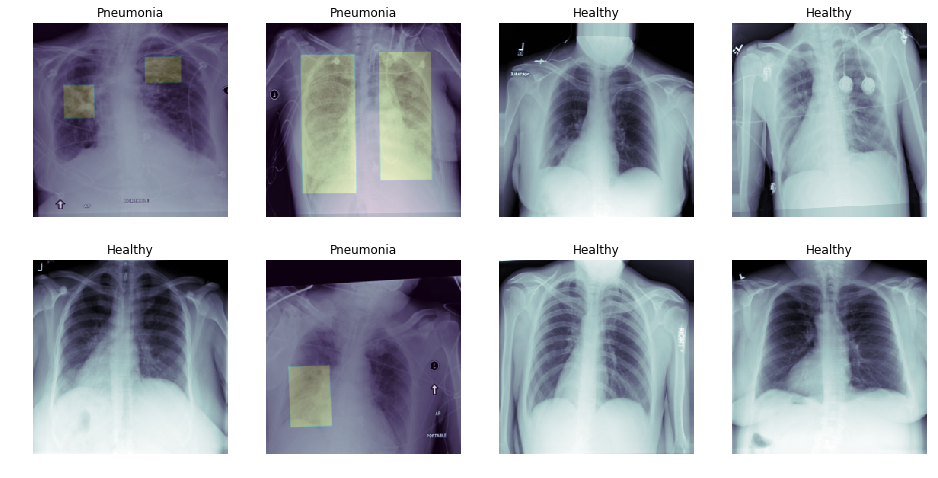

In [30]:
train_src, train_tar = next(train_generator)
valid_src, valid_tar = next(valid_generator)

print(train_src.shape, train_tar.shape)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (t_src, t_tar, ax) in zip(train_src, train_tar, m_axs.flatten()):
    ax.imshow(t_src[:,:,0], cmap = 'bone')
    if np.all(t_tar<1):
        # If the mask is all 0 then there's no pneumonia
        title = 'Healthy'
    else:
        title = 'Pneumonia'
        ax.imshow(t_tar[:,:,0], alpha=0.2)
        print(train_tar[train_tar>200])
    ax.set_title('%s' % title)
    ax.axis('off')

In [22]:
print(train_src.shape[1:])
base_pretrained_model = PTModel(input_shape = train_src.shape[1:], 
                                include_top = False)
base_pretrained_model.trainable = False
#print(base_pretrained_model.get_input_shape_at(0)[1:])

(256, 256, 3)


In [125]:
#pt_features = Input(train_src.shape[1:], name = 'feature_input')
#pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]

#bn_features = BatchNormalization()(pt_features)
#gap = GlobalAveragePooling2D()(bn_features)
#gap_dr = Dropout(DROPOUT)(gap)
#dr_steps = Dropout(DROPOUT)(Dense(DENSE_COUNT, activation = 'linear', use_bias=False)(gap_dr))
#dr_steps = BatchNormalization()(dr_steps)
#dr_steps = layers.LeakyReLU(0.1)(dr_steps)
#out_layer = Dense(train_tar.shape[1], activation = 'softmax')(dr_steps)

#attn_model = Model(inputs = [pt_features], 
#                   outputs = [out_layer], name = 'trained_model')


pt_features = Input(base_pretrained_model.get_output_shape_at(0)[1:], name = 'feature_input')
outputs = BatchNormalization(momentum=0.9)(pt_features)
outputs = LeakyReLU(0)(outputs)
outputs = UpSampling2D(4)(outputs)
outputs = Conv2D(1, 3, padding='same', use_bias=False)(outputs)
outputs = BatchNormalization(momentum=0.9)(outputs)
outputs = LeakyReLU(0)(outputs)
outputs = Conv2D(1, 1, padding='same', activation='sigmoid', use_bias=False)(outputs)
outputs = LeakyReLU(0)(outputs)
outputs = UpSampling2D(8)(outputs)

model = Model(inputs=pt_features,
              outputs=outputs)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_input (InputLayer)   (None, 8, 8, 1024)        0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 8, 8, 1024)        4096      
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 8, 8, 1024)        0         
_________________________________________________________________
up_sampling2d_36 (UpSampling (None, 32, 32, 1024)      0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 32, 32, 1)         9216      
_________________________________________________________________
batch_normalization_36 (Batc (None, 32, 32, 1)         4         
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 32, 32, 1)         0         
__________

In [126]:
pneu_model = Sequential(name = 'combined_model')
pneu_model.add(base_pretrained_model)
pneu_model.add(model)
pneu_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 8, 8, 1024)        7037504   
_________________________________________________________________
model_21 (Model)             (None, 256, 256, 1)       13317     
Total params: 7,050,821
Trainable params: 11,267
Non-trainable params: 7,039,554
_________________________________________________________________


In [127]:
# This is the percentage overlap between predicted box and actual
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

def iou_bce_loss(y_true, y_pred):
    split0, split1, split2 = tf.split(y_true, num_or_size_splits=3, axis=3)
    split0 = tf.round(tf.divide(split0, 255))
    return iou_loss(split0, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    split0, split1, split2 = tf.split(y_true, num_or_size_splits=3, axis=3)
    split0 = tf.round(tf.divide(split0, 255))
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(split0 * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(split0, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

# create network and compiler
pneu_model.compile(optimizer='adam',
                   loss=iou_bce_loss,
                   metrics=['accuracy', mean_iou])

# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = 25
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

In [26]:
weight_path="{}_weights.best.hdf5".format('lung_opacity')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, 
                                   patience=10, verbose=1, mode='auto', 
                                   min_delta=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [113]:
history = pneu_model.fit_generator(train_generator, 
                                   steps_per_epoch=train_image_generator.n//BATCH_SIZE,
                                   validation_data=valid_generator,
                                   validation_steps=valid_image_generator.n//BATCH_SIZE,
                                   epochs=10,
                                   callbacks=callbacks_list,
                                   workers=1
                                   )

Epoch 1/10
1444/1444 [==============================] - 552s 382ms/step - loss: 0.9482 - acc: 0.9739 - mean_iou: 0.7941 - val_loss: 0.9404 - val_acc: 0.9524 - val_mean_iou: 0.6506

Epoch 00001: val_loss improved from 0.94663 to 0.94037, saving model to lung_opacity_weights.best.hdf5
Epoch 2/10
1444/1444 [==============================] - 543s 376ms/step - loss: 0.8614 - acc: 0.9743 - mean_iou: 0.7948 - val_loss: 0.9598 - val_acc: 0.9514 - val_mean_iou: 0.6439

Epoch 00002: val_loss did not improve from 0.94037
Epoch 3/10
1444/1444 [==============================] - 543s 376ms/step - loss: 0.8465 - acc: 0.9739 - mean_iou: 0.7935 - val_loss: 0.9838 - val_acc: 0.9553 - val_mean_iou: 0.6576

Epoch 00003: val_loss did not improve from 0.94037
Epoch 4/10
1444/1444 [==============================] - 543s 376ms/step - loss: 0.8406 - acc: 0.9740 - mean_iou: 0.7947 - val_loss: 0.9721 - val_acc: 0.9506 - val_mean_iou: 0.6380

Epoch 00004: val_loss did not improve from 0.94037
Epoch 5/10
1444/1444

KeyboardInterrupt: 

In [114]:
pneu_model.load_weights(weight_path)
pneu_model.save('full_model.h5')

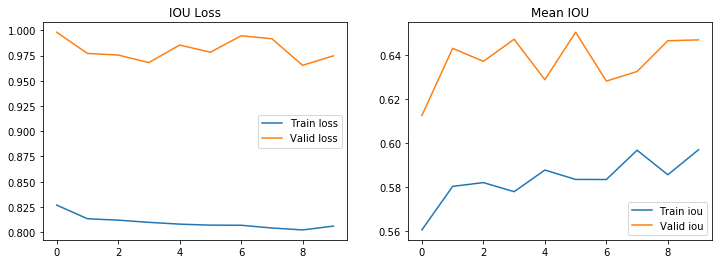

In [115]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.title("IOU Loss")
#plt.subplot(132)
#plt.plot(history.epoch, history.history["acc"], label="Train accuracy")
#plt.plot(history.epoch, history.history["val_acc"], label="Valid accuracy")
#plt.legend()
plt.subplot(122)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.title("Mean IOU")
plt.show()

In [116]:
valid_src, valid_tar = next(valid_generator)
preds = pneu_model.predict(valid_src,
                            batch_size = BATCH_SIZE, 
                            verbose = True)

16/16 [==============================] - 6s 382ms/step


[[0.5]
 [0.5]
 [0.5]
 ...
 [0.5]
 [0.5]
 [0.5]]
[[0.5]
 [0.5]
 [0.5]
 ...
 [0.5]
 [0.5]
 [0.5]]
[[0.5]
 [0.5]
 [0.5]
 ...
 [0.5]
 [0.5]
 [0.5]]
[[0.5]
 [0.5]
 [0.5]
 ...
 [0.5]
 [0.5]
 [0.5]]
[[0.5]
 [0.5]
 [0.5]
 ...
 [0.5]
 [0.5]
 [0.5]]
[[0.5]
 [0.5]
 [0.5]
 ...
 [0.5]
 [0.5]
 [0.5]]
[[0.5]
 [0.5]
 [0.5]
 ...
 [0.5]
 [0.5]
 [0.5]]
[[0.5]
 [0.5]
 [0.5]
 ...
 [0.5]
 [0.5]
 [0.5]]
[[0.5]
 [0.5]
 [0.5]
 ...
 [0.5]
 [0.5]
 [0.5]]
[[0.5]
 [0.5]
 [0.5]
 ...
 [0.5]
 [0.5]
 [0.5]]
[[0.5]
 [0.5]
 [0.5]
 ...
 [0.5]
 [0.5]
 [0.5]]
[[0.5]
 [0.5]
 [0.5]
 ...
 [0.5]
 [0.5]
 [0.5]]
[[0.49638662]
 [0.49638662]
 [0.49638662]
 ...
 [0.5       ]
 [0.5       ]
 [0.5       ]]
[[0.5]
 [0.5]
 [0.5]
 ...
 [0.5]
 [0.5]
 [0.5]]
[[0.5]
 [0.5]
 [0.5]
 ...
 [0.5]
 [0.5]
 [0.5]]
[[0.5]
 [0.5]
 [0.5]
 ...
 [0.5]
 [0.5]
 [0.5]]


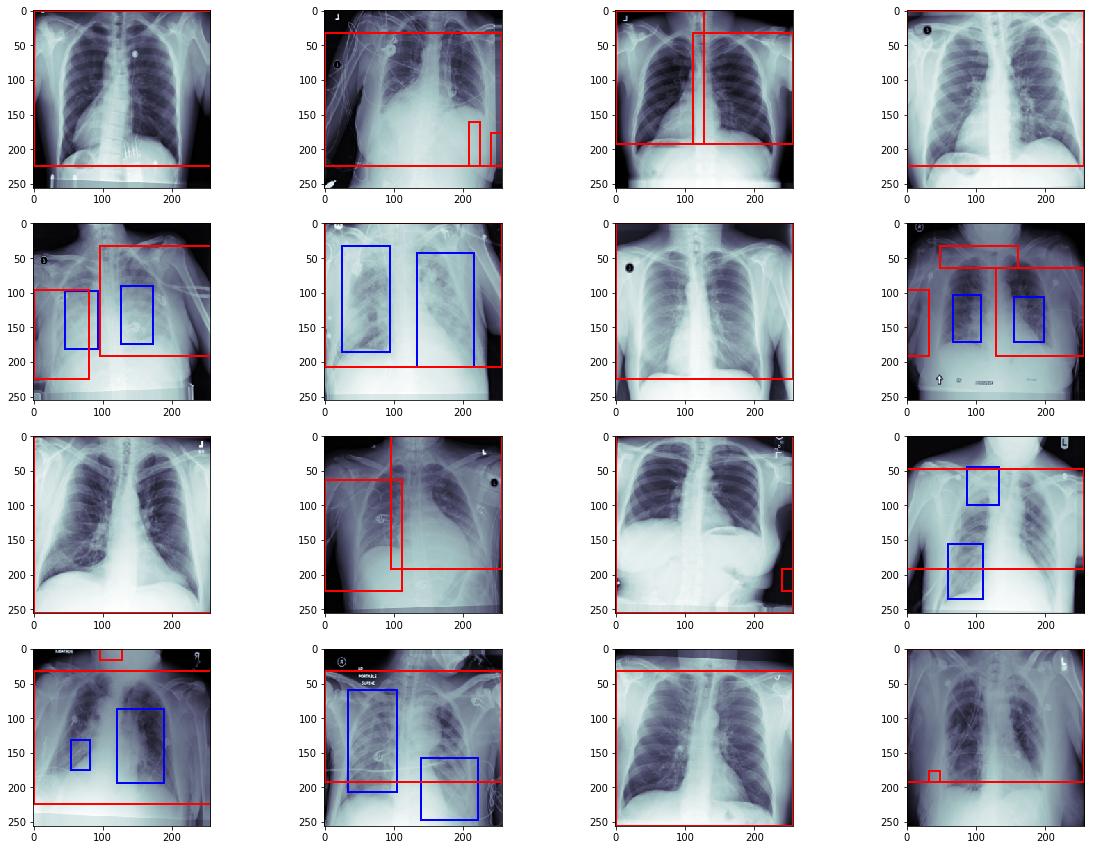

In [124]:
f, axarr = plt.subplots(4, 4, figsize=(20,15))
axarr = axarr.ravel()
axidx = 0
# loop through batch
for img, msk, pred in zip(valid_src, valid_tar, preds):
    # plot image
    msk = msk/255
    axarr[axidx].imshow(img[:, :, 0], cmap='bone')
    # threshold true mask
    comp = msk[:, :, 0] > 0.5
    # apply connected components
    comp = measure.label(comp)
    # apply bounding boxes
    predictionString = ''
    for region in measure.regionprops(comp):
        # retrieve x, y, height and width
        y, x, y2, x2 = region.bbox
        height = y2 - y
        width = x2 - x
        axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
    # threshold predicted mask
    comp = pred[:, :, 0] > 0.49
    print(pred[comp])
    # apply connected components
    comp = measure.label(comp)
    # apply bounding boxes
    predictionString = ''
    for region in measure.regionprops(comp):
        # retrieve x, y, height and width
        y, x, y2, x2 = region.bbox
        height = y2 - y
        width = x2 - x
        axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
    axidx += 1
plt.show()
# only plot one batch